In [1]:
import tensorflow as tf
import os
import glob
import cv2
import numpy as np
import pandas as pd
import random

In [11]:
EPS = 1e-12

train_picture_path = './/dataset2//train//0.normal//'
label_picture_path = './/dataset2//train//1.abnormal//'
train_save_path = './/train_save//'
model_save_path = './save_model/'
test_picture_path = './dataset2/train/0.normal/'
test_save_path = './test_save/'

train_picture_list = glob.glob(os.path.join(train_picture_path, "*"))
label_picture_list = glob.glob(os.path.join(label_picture_path, "*"))

In [3]:
def batch_norm(inp,name="batch_norm"):
    batch_norm_fi = tf.keras.layers.BatchNormalization()(inp, training=True)
    return batch_norm_fi

def lrelu(x, leak=0.2, name = "lrelu"):
    return tf.maximum(x, leak*x)

def l1_loss(src, dst):
    return tf.reduce_mean(tf.abs(src - dst))

In [4]:
gen_input = tf.keras.Input(shape=(256,256,3), name='train_img')
c1 = tf.keras.layers.Conv2D(filters=64,kernel_size=4,strides=2,padding='same',input_shape=[256,256,3])(gen_input)
b1 = batch_norm(c1)
#[1,128,128,64]
c2 = tf.keras.layers.Conv2D(filters=128,kernel_size=4,strides=2,padding='same',use_bias=False)(lrelu(b1))
b2 = batch_norm(c2)
#[1,64,64,256]
c3 = tf.keras.layers.Conv2D(filters=256,kernel_size=4,strides=2,padding='same',use_bias=False)(lrelu(b2))
b3 = batch_norm(c3)
#[1,32,32,256]
c4 = tf.keras.layers.Conv2D(filters=512,kernel_size=4,strides=2,padding='same',use_bias=False)(lrelu(b3))
b4 = batch_norm(c4)
#[1,16,16,512]
c5 = tf.keras.layers.Conv2D(filters=512,kernel_size=4,strides=2,padding='same',use_bias=False)(lrelu(b4))
b5 = batch_norm(c5)
#[1,8,8,512]
c6 = tf.keras.layers.Conv2D(filters=512,kernel_size=4,strides=2,padding='same',use_bias=False)(lrelu(b5))
b6 = batch_norm(c6)
#[1,4,4,512]
c7 = tf.keras.layers.Conv2D(filters=512,kernel_size=4,strides=2,padding='same',use_bias=False)(lrelu(b6))
b7 = batch_norm(c7)
#[1,2,2,512]
c8 = tf.keras.layers.Conv2D(filters=512,kernel_size=4,strides=2,padding='same',use_bias=False)(lrelu(b7))
b8 = batch_norm(c8)
#[1,1,1,512]

d1 = tf.keras.layers.Conv2DTranspose(512,kernel_size=4,strides=2,padding='same',use_bias=False)(b8)
d1 = tf.nn.dropout(d1, 0.5)
d1 = tf.concat([batch_norm(d1, name='g_bn_d1'), b7],3)
#[1,2,2,512]
d2 = tf.keras.layers.Conv2DTranspose(512,kernel_size=4,strides=2,padding='same',use_bias=False)(tf.nn.relu(d1))
d2 = tf.nn.dropout(d2, 0.5)
d2 = tf.concat([batch_norm(d2, name='g_bn_d2'), b6],3)
#[1,4,4,512]
d3 = tf.keras.layers.Conv2DTranspose(512,kernel_size=4,strides=2,padding='same',use_bias=False)(tf.nn.relu(d2))
d3 = tf.nn.dropout(d3, 0.5)
d3 = tf.concat([batch_norm(d3, name='g_bn_d3'), b5],3)
#[1,8.8.512]
d4 = tf.keras.layers.Conv2DTranspose(512,kernel_size=4,strides=2,padding='same',use_bias=False)(tf.nn.relu(d3))
d4 = tf.concat([batch_norm(d4, name='g_bn_d4'), b4],3)
#[1,16,16,512]
d5 = tf.keras.layers.Conv2DTranspose(256,kernel_size=4,strides=2,padding='same',use_bias=False)(tf.nn.relu(d4))
d5 = tf.concat([batch_norm(d5, name='g_bn_d5'), b3],3)
#[1,32,32,256]
d6 = tf.keras.layers.Conv2DTranspose(128,kernel_size=4,strides=2,padding='same',use_bias=False)(tf.nn.relu(d5))
d6 = tf.concat([batch_norm(d6, name='g_bn_d6'), b2],3)
#[1,64,64,128]
d7 = tf.keras.layers.Conv2DTranspose(64,kernel_size=4,strides=2,padding='same',use_bias=False)(tf.nn.relu(d6))
d7 = tf.concat([batch_norm(d7, name='g_bn_d7'), b1],3)
#[1,128,128,64]
d8 = tf.keras.layers.Conv2DTranspose(3,kernel_size=4,strides=2,padding='same',use_bias=False)(tf.nn.relu(d7))
gen_out = tf.nn.tanh(d8)
#[1.256,256,3]
gen_model = tf.keras.Model(inputs=gen_input, outputs=gen_out, name='gen_model')

dis_input = tf.keras.Input(shape=(256,256,6), name='train_img')
h1 = tf.keras.layers.Conv2D(64,(4,4),strides=(2,2),padding='same',input_shape=[256,256,3])(dis_input)
h1 = lrelu(h1)
#1*128*128*64
h2 = tf.keras.layers.Conv2D(128,(4,4),strides=(2,2),padding='same',use_bias=False)(h1)
h2 = batch_norm(h2)
h2 = lrelu(h2)
#1*64*64*128
h3 = tf.keras.layers.Conv2D(256,(4,4),strides=(2,2),padding='same',use_bias=False)(h2)
h3 = batch_norm(h3)
h3 = lrelu(h3)
#1*32*32*256
h4 = tf.keras.layers.Conv2D(512,(4,4),strides=(1,1),padding='same',use_bias=False)(h3)
h4 = batch_norm(h4)
h4 = lrelu(h4)
#1*32*32*512
output = tf.keras.layers.Conv2D(1,(4,4),strides=(1,1),padding='same',use_bias=False)(h4)
#1*32*32*1
dis_out = tf.sigmoid(output)
dis_model = tf.keras.Model(inputs=dis_input, outputs=dis_out, name='dis_model')

discriminator_optimizer = tf.keras.optimizers.Adam(2*1e-4)#自适应学习率优化算法
generator_optimizer = tf.keras.optimizers.Adam(2*1e-4)

In [10]:
cls_input = tf.keras.Input(shape=(256,256,6), name='train_img')
h1 = tf.keras.layers.Conv2D(64,(4,4),strides=(2,2),padding='same',input_shape=[256,256,3])(cls_input)
h1 = lrelu(h1)
h1 = tf.keras.layers.MaxPooling2D(2,2)(h1)
#1*128*128*64
h2 = tf.keras.layers.Conv2D(128,(4,4),strides=(2,2),padding='same',use_bias=False)(h1)
h2 = batch_norm(h2)
h2 = lrelu(h2)
h2 = tf.keras.layers.MaxPooling2D(2,2)(h2)
#1*64*64*128
h3 = tf.keras.layers.Conv2D(256,(4,4),strides=(2,2),padding='same',use_bias=False)(h2)
h3 = batch_norm(h3)
h3 = lrelu(h3)
h3 = tf.keras.layers.MaxPooling2D(2,2)(h3)
#1*32*32*256
h4 = tf.keras.layers.Conv2D(512,(4,4),strides=(1,1),padding='same',use_bias=False)(h3)
h4 = batch_norm(h4)
h4 = lrelu(h4)
h4 = tf.keras.layers.MaxPooling2D(2,2)(h4)
#1*32*32*512
h5 = tf.keras.layers.Flatten()(h4)
h5 = tf.keras.layers.Dense(128, activation='relu')(h5)
cls_out = tf.keras.layers.Dense(10, activation='sigmoid')(h5)
#output = tf.keras.layers.Conv2D(1,(4,4),strides=(1,1),padding='same',use_bias=False)(h5)
#1*32*32*1
# cls_out = tf.sigmoid(output)
cls_model = tf.keras.Model(inputs=cls_input, outputs=cls_out, name='dis_model')

classifier_optimizer = tf.keras.optimizers.Adam(2*1e-4)#自适应学习率优化算法

In [5]:
def train_step(batch_picture,batch_label,count):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_label = gen_model(batch_picture)
        dis_real = dis_model(tf.concat([batch_picture, batch_label], 3))
        dis_fake = dis_model(tf.concat([batch_picture, gen_label], 3))
        gen_loss_L1 = tf.reduce_mean(l1_loss(gen_label, batch_label))
        gen_loss = tf.reduce_mean(-tf.math.log(dis_fake + EPS)) + 100 * gen_loss_L1
        #+ 1*tf.reduce_mean(l1_loss(gen_label, batch_label))
        dis_loss = tf.reduce_mean(-(tf.math.log(dis_real + EPS) + tf.math.log(1 - dis_fake + EPS)))
        
    gradients_of_generator = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(dis_loss, dis_model.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, dis_model.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen_model.trainable_variables))
    
    return gen_loss,dis_loss,gen_label

In [6]:
def evaluate(runstep,test_picture_path,test_save_path):
    gen_model.load_weights(model_save_path)
    test_picture_list = glob.glob(os.path.join(test_picture_path, "*"))
    for step in range(len(test_picture_list)):
        testimg_path = test_picture_list[step]
        pic_name, _ = os.path.splitext(os.path.basename(testimg_path))
        picture =  cv2.imread(testimg_path)
        height = picture.shape[0] #得到图片的高
        width = picture.shape[1] #得到图片的宽
        picture_resize_t = cv2.resize(picture, (256, 256))
        picture_resize = picture_resize_t / 127.5 - 1.
        batch_picture = np.expand_dims(np.array(picture_resize).astype(np.float32), axis = 0)
        gen_label = gen_model(batch_picture)
        out_img = (gen_label[0] + 1.) * 127.5
        out_img = out_img.numpy()
        out_img = cv2.resize(out_img, (width, height))
        write_image_name = test_save_path + str(runstep) + '_' + str(step) + ".jpg"
        #write_image_name = test_save_path + pic_name + ".png"
        cv2.imwrite(write_image_name, out_img)
        print(step)

In [7]:
def train():
    gen_ls = []
    dis_ls = []
    counter = 0
    gen_model.load_weights(model_save_path)
    for epoch in range(0,100):
        random.shuffle(train_picture_list)
        for step in range(len(train_picture_list)):
            counter += 1
            img_path = train_picture_list[step]
            pic_name, _ = os.path.splitext(os.path.basename(img_path))
            label_path = label_picture_path + pic_name + '.jpg'
            picture =  cv2.imread(img_path)
            label =  cv2.imread(label_path)
            height = picture.shape[0] #得到图片的高
            width = picture.shape[1] #得到图片的宽
            picture_resize_t = cv2.resize(picture, (256, 256))
            picture_resize = picture_resize_t / 127.5 - 1.
            label_resize_t = cv2.resize(label, (256, 256))
            label_resize = label_resize_t / 127.5 - 1.
            batch_picture = np.expand_dims(np.array(picture_resize).astype(np.float32), axis = 0)
            batch_label = np.expand_dims(np.array(label_resize).astype(np.float32), axis = 0)
            gen_loss,dis_loss,gen_label = train_step(batch_picture,batch_label,counter) 
            gen_ls.append(gen_loss)
            dis_ls.append(dis_loss)
            if counter % 500 == 0:
                runstep,test_picture_path,test_save_path(counter)
                gen_model.save_weights(model_save_path)
            if counter % 100 == 0:
                out_img = (gen_label[0] + 1.) * 127.5
                out_img = out_img.numpy() 
                out_img = cv2.resize(out_img, (width, height))
                #save_img = np.concatenate((picture_resize_t,out_img,label_resize_t), axis=1)
                write_image_name = train_save_path + str(counter) + ".jpg"
                cv2.imwrite(write_image_name, out_img)
            gen_model.save_weights(model_save_path)
            print('epoch {:d} step {:d} \t gen_loss = {:.3f}, dis_loss = {:.3f}'.format(epoch, step, gen_loss, dis_loss))
    return gen_ls, dis_ls


In [43]:
gen_loss,dis_loss = train()

epoch 0 step 0 	 gen_loss = 9.873, dis_loss = 1.053
epoch 0 step 1 	 gen_loss = 9.044, dis_loss = 1.097
epoch 0 step 2 	 gen_loss = 7.787, dis_loss = 1.479
epoch 0 step 3 	 gen_loss = 14.137, dis_loss = 1.414
epoch 0 step 4 	 gen_loss = 11.146, dis_loss = 1.359
epoch 0 step 5 	 gen_loss = 7.453, dis_loss = 1.365
epoch 0 step 6 	 gen_loss = 8.153, dis_loss = 1.328
epoch 0 step 7 	 gen_loss = 7.353, dis_loss = 1.336
epoch 0 step 8 	 gen_loss = 9.954, dis_loss = 1.304
epoch 0 step 9 	 gen_loss = 8.349, dis_loss = 1.345
epoch 0 step 10 	 gen_loss = 35.490, dis_loss = 1.098
epoch 0 step 11 	 gen_loss = 23.562, dis_loss = 1.095
epoch 0 step 12 	 gen_loss = 7.579, dis_loss = 1.394
epoch 0 step 13 	 gen_loss = 17.054, dis_loss = 1.056
epoch 0 step 14 	 gen_loss = 12.353, dis_loss = 1.284
epoch 0 step 15 	 gen_loss = 11.341, dis_loss = 1.191
epoch 0 step 16 	 gen_loss = 10.500, dis_loss = 1.234
epoch 0 step 17 	 gen_loss = 16.725, dis_loss = 1.207
epoch 0 step 18 	 gen_loss = 7.544, dis_loss = 

epoch 2 step 45 	 gen_loss = 7.162, dis_loss = 1.272
epoch 2 step 46 	 gen_loss = 25.011, dis_loss = 0.481
epoch 2 step 47 	 gen_loss = 5.924, dis_loss = 1.456
epoch 2 step 48 	 gen_loss = 11.386, dis_loss = 0.936
epoch 2 step 49 	 gen_loss = 6.657, dis_loss = 1.439
epoch 2 step 50 	 gen_loss = 6.731, dis_loss = 1.467
epoch 2 step 51 	 gen_loss = 11.734, dis_loss = 1.545
epoch 2 step 52 	 gen_loss = 7.548, dis_loss = 1.240
epoch 2 step 53 	 gen_loss = 8.761, dis_loss = 1.092
epoch 2 step 54 	 gen_loss = 6.001, dis_loss = 1.409
epoch 3 step 0 	 gen_loss = 6.548, dis_loss = 1.486
epoch 3 step 1 	 gen_loss = 21.220, dis_loss = 0.619
epoch 3 step 2 	 gen_loss = 4.948, dis_loss = 1.573
epoch 3 step 3 	 gen_loss = 6.909, dis_loss = 1.464
epoch 3 step 4 	 gen_loss = 10.003, dis_loss = 1.166
epoch 3 step 5 	 gen_loss = 16.488, dis_loss = 0.782
epoch 3 step 6 	 gen_loss = 9.417, dis_loss = 1.199
epoch 3 step 7 	 gen_loss = 12.068, dis_loss = 1.171
epoch 3 step 8 	 gen_loss = 9.942, dis_loss = 1

epoch 5 step 35 	 gen_loss = 6.225, dis_loss = 1.259
epoch 5 step 36 	 gen_loss = 11.880, dis_loss = 0.768
epoch 5 step 37 	 gen_loss = 5.857, dis_loss = 1.092
epoch 5 step 38 	 gen_loss = 4.801, dis_loss = 1.388
epoch 5 step 39 	 gen_loss = 9.074, dis_loss = 0.770
epoch 5 step 40 	 gen_loss = 21.066, dis_loss = 0.679
epoch 5 step 41 	 gen_loss = 4.138, dis_loss = 1.484
epoch 5 step 42 	 gen_loss = 5.077, dis_loss = 1.246
epoch 5 step 43 	 gen_loss = 4.852, dis_loss = 1.483
epoch 5 step 44 	 gen_loss = 7.240, dis_loss = 1.125
epoch 5 step 45 	 gen_loss = 7.050, dis_loss = 1.076
epoch 5 step 46 	 gen_loss = 28.028, dis_loss = 0.501
epoch 5 step 47 	 gen_loss = 23.135, dis_loss = 0.606
epoch 5 step 48 	 gen_loss = 7.071, dis_loss = 1.066
epoch 5 step 49 	 gen_loss = 9.606, dis_loss = 1.028
epoch 5 step 50 	 gen_loss = 14.897, dis_loss = 1.049
epoch 5 step 51 	 gen_loss = 9.982, dis_loss = 0.983
epoch 5 step 52 	 gen_loss = 7.381, dis_loss = 0.804
epoch 5 step 53 	 gen_loss = 22.142, dis_

epoch 8 step 25 	 gen_loss = 6.157, dis_loss = 1.450
epoch 8 step 26 	 gen_loss = 8.022, dis_loss = 0.968
epoch 8 step 27 	 gen_loss = 5.242, dis_loss = 1.209
epoch 8 step 28 	 gen_loss = 8.478, dis_loss = 1.001
epoch 8 step 29 	 gen_loss = 5.451, dis_loss = 1.464
epoch 8 step 30 	 gen_loss = 7.629, dis_loss = 0.645
epoch 8 step 31 	 gen_loss = 8.110, dis_loss = 1.225
epoch 8 step 32 	 gen_loss = 6.962, dis_loss = 1.451
epoch 8 step 33 	 gen_loss = 9.662, dis_loss = 1.114
epoch 8 step 34 	 gen_loss = 4.972, dis_loss = 1.988
epoch 8 step 35 	 gen_loss = 5.136, dis_loss = 1.454
epoch 8 step 36 	 gen_loss = 11.306, dis_loss = 1.058
epoch 8 step 37 	 gen_loss = 5.078, dis_loss = 0.992
epoch 8 step 38 	 gen_loss = 7.688, dis_loss = 0.737
epoch 8 step 39 	 gen_loss = 7.765, dis_loss = 0.998
epoch 8 step 40 	 gen_loss = 6.105, dis_loss = 1.463
epoch 8 step 41 	 gen_loss = 5.352, dis_loss = 1.068
epoch 8 step 42 	 gen_loss = 6.381, dis_loss = 0.905
epoch 8 step 43 	 gen_loss = 4.070, dis_loss 

epoch 11 step 11 	 gen_loss = 6.760, dis_loss = 1.413
epoch 11 step 12 	 gen_loss = 4.492, dis_loss = 0.908
epoch 11 step 13 	 gen_loss = 4.819, dis_loss = 1.235
epoch 11 step 14 	 gen_loss = 4.310, dis_loss = 1.625
epoch 11 step 15 	 gen_loss = 7.468, dis_loss = 0.862
epoch 11 step 16 	 gen_loss = 3.432, dis_loss = 1.479
epoch 11 step 17 	 gen_loss = 8.442, dis_loss = 0.862
epoch 11 step 18 	 gen_loss = 5.055, dis_loss = 1.130
epoch 11 step 19 	 gen_loss = 5.429, dis_loss = 0.962
epoch 11 step 20 	 gen_loss = 9.110, dis_loss = 0.853
epoch 11 step 21 	 gen_loss = 8.768, dis_loss = 0.855
epoch 11 step 22 	 gen_loss = 9.514, dis_loss = 0.724
epoch 11 step 23 	 gen_loss = 7.028, dis_loss = 0.749
epoch 11 step 24 	 gen_loss = 12.215, dis_loss = 0.477
epoch 11 step 25 	 gen_loss = 5.624, dis_loss = 0.953
epoch 11 step 26 	 gen_loss = 3.543, dis_loss = 1.417
epoch 11 step 27 	 gen_loss = 9.056, dis_loss = 0.823
epoch 11 step 28 	 gen_loss = 7.682, dis_loss = 0.716
epoch 11 step 29 	 gen_loss

epoch 13 step 53 	 gen_loss = 7.509, dis_loss = 0.720
epoch 13 step 54 	 gen_loss = 9.095, dis_loss = 0.575
epoch 14 step 0 	 gen_loss = 6.879, dis_loss = 0.675
epoch 14 step 1 	 gen_loss = 6.762, dis_loss = 0.470
epoch 14 step 2 	 gen_loss = 6.215, dis_loss = 0.436
epoch 14 step 3 	 gen_loss = 4.805, dis_loss = 0.621
epoch 14 step 4 	 gen_loss = 8.885, dis_loss = 1.219
epoch 14 step 5 	 gen_loss = 8.490, dis_loss = 0.399
epoch 14 step 6 	 gen_loss = 7.819, dis_loss = 0.472
epoch 14 step 7 	 gen_loss = 3.986, dis_loss = 1.374
epoch 14 step 8 	 gen_loss = 5.567, dis_loss = 0.857
epoch 14 step 9 	 gen_loss = 3.729, dis_loss = 1.158
epoch 14 step 10 	 gen_loss = 10.660, dis_loss = 0.270
epoch 14 step 11 	 gen_loss = 4.275, dis_loss = 0.855
epoch 14 step 12 	 gen_loss = 5.120, dis_loss = 0.812
epoch 14 step 13 	 gen_loss = 4.322, dis_loss = 0.931
epoch 14 step 14 	 gen_loss = 8.022, dis_loss = 0.484
epoch 14 step 15 	 gen_loss = 4.180, dis_loss = 1.106
epoch 14 step 16 	 gen_loss = 4.930, 

epoch 16 step 40 	 gen_loss = 3.558, dis_loss = 1.202
epoch 16 step 41 	 gen_loss = 5.306, dis_loss = 1.606
epoch 16 step 42 	 gen_loss = 12.910, dis_loss = 0.770
epoch 16 step 43 	 gen_loss = 3.593, dis_loss = 2.028
epoch 16 step 44 	 gen_loss = 4.441, dis_loss = 1.625
epoch 16 step 45 	 gen_loss = 3.941, dis_loss = 1.821
epoch 16 step 46 	 gen_loss = 6.056, dis_loss = 1.713
epoch 16 step 47 	 gen_loss = 4.535, dis_loss = 1.555
epoch 16 step 48 	 gen_loss = 3.871, dis_loss = 1.398
epoch 16 step 49 	 gen_loss = 7.014, dis_loss = 1.580
epoch 16 step 50 	 gen_loss = 11.123, dis_loss = 1.319
epoch 16 step 51 	 gen_loss = 10.605, dis_loss = 0.863
epoch 16 step 52 	 gen_loss = 6.425, dis_loss = 1.280
epoch 16 step 53 	 gen_loss = 4.521, dis_loss = 1.400
epoch 16 step 54 	 gen_loss = 4.295, dis_loss = 1.357
epoch 17 step 0 	 gen_loss = 3.956, dis_loss = 1.229
epoch 17 step 1 	 gen_loss = 6.182, dis_loss = 0.696
epoch 17 step 2 	 gen_loss = 3.468, dis_loss = 1.379
epoch 17 step 3 	 gen_loss =

epoch 19 step 24 	 gen_loss = 2.701, dis_loss = 2.356
epoch 19 step 25 	 gen_loss = 10.403, dis_loss = 0.699
epoch 19 step 26 	 gen_loss = 5.747, dis_loss = 1.138
epoch 19 step 27 	 gen_loss = 6.034, dis_loss = 1.989
epoch 19 step 28 	 gen_loss = 3.475, dis_loss = 1.535
epoch 19 step 29 	 gen_loss = 8.785, dis_loss = 0.956
epoch 19 step 30 	 gen_loss = 3.437, dis_loss = 1.495
epoch 19 step 31 	 gen_loss = 2.977, dis_loss = 1.804
epoch 19 step 32 	 gen_loss = 7.032, dis_loss = 0.401
epoch 19 step 33 	 gen_loss = 8.341, dis_loss = 0.484
epoch 19 step 34 	 gen_loss = 5.676, dis_loss = 0.645
epoch 19 step 35 	 gen_loss = 7.403, dis_loss = 0.847
epoch 19 step 36 	 gen_loss = 8.035, dis_loss = 0.713
epoch 19 step 37 	 gen_loss = 8.965, dis_loss = 0.693
epoch 19 step 38 	 gen_loss = 5.697, dis_loss = 0.529
epoch 19 step 39 	 gen_loss = 3.740, dis_loss = 0.936
epoch 19 step 40 	 gen_loss = 7.881, dis_loss = 0.389
epoch 19 step 41 	 gen_loss = 2.935, dis_loss = 1.513
epoch 19 step 42 	 gen_loss

epoch 22 step 11 	 gen_loss = 13.891, dis_loss = 0.752
epoch 22 step 12 	 gen_loss = 9.293, dis_loss = 0.436
epoch 22 step 13 	 gen_loss = 10.329, dis_loss = 0.250
epoch 22 step 14 	 gen_loss = 4.463, dis_loss = 0.695
epoch 22 step 15 	 gen_loss = 12.459, dis_loss = 0.307
epoch 22 step 16 	 gen_loss = 14.231, dis_loss = 0.546
epoch 22 step 17 	 gen_loss = 7.382, dis_loss = 0.272
epoch 22 step 18 	 gen_loss = 11.822, dis_loss = 0.176
epoch 22 step 19 	 gen_loss = 5.456, dis_loss = 0.706
epoch 22 step 20 	 gen_loss = 4.656, dis_loss = 0.366
epoch 22 step 21 	 gen_loss = 6.556, dis_loss = 0.191
epoch 22 step 22 	 gen_loss = 7.512, dis_loss = 0.145
epoch 22 step 23 	 gen_loss = 7.369, dis_loss = 0.149
epoch 22 step 24 	 gen_loss = 9.522, dis_loss = 0.162
epoch 22 step 25 	 gen_loss = 7.938, dis_loss = 0.176
epoch 22 step 26 	 gen_loss = 3.679, dis_loss = 0.846
epoch 22 step 27 	 gen_loss = 10.161, dis_loss = 0.108
epoch 22 step 28 	 gen_loss = 6.601, dis_loss = 0.256
epoch 22 step 29 	 gen

epoch 24 step 53 	 gen_loss = 13.175, dis_loss = 0.106
epoch 24 step 54 	 gen_loss = 15.241, dis_loss = 1.237
epoch 25 step 0 	 gen_loss = 8.701, dis_loss = 0.207
epoch 25 step 1 	 gen_loss = 6.535, dis_loss = 0.483
epoch 25 step 2 	 gen_loss = 5.520, dis_loss = 0.754
epoch 25 step 3 	 gen_loss = 5.713, dis_loss = 0.127
epoch 25 step 4 	 gen_loss = 5.553, dis_loss = 0.893
epoch 25 step 5 	 gen_loss = 3.866, dis_loss = 1.014
epoch 25 step 6 	 gen_loss = 6.015, dis_loss = 0.168
epoch 25 step 7 	 gen_loss = 6.611, dis_loss = 0.235
epoch 25 step 8 	 gen_loss = 7.732, dis_loss = 0.353
epoch 25 step 9 	 gen_loss = 14.858, dis_loss = 0.098
epoch 25 step 10 	 gen_loss = 8.788, dis_loss = 0.543
epoch 25 step 11 	 gen_loss = 4.198, dis_loss = 0.527
epoch 25 step 12 	 gen_loss = 7.185, dis_loss = 0.962
epoch 25 step 13 	 gen_loss = 11.199, dis_loss = 0.064
epoch 25 step 14 	 gen_loss = 7.997, dis_loss = 0.342
epoch 25 step 15 	 gen_loss = 8.119, dis_loss = 0.415
epoch 25 step 16 	 gen_loss = 6.47

epoch 27 step 37 	 gen_loss = 7.450, dis_loss = 1.431
epoch 27 step 38 	 gen_loss = 6.278, dis_loss = 0.347
epoch 27 step 39 	 gen_loss = 4.148, dis_loss = 0.450
epoch 27 step 40 	 gen_loss = 4.286, dis_loss = 0.442
epoch 27 step 41 	 gen_loss = 8.457, dis_loss = 0.138
epoch 27 step 42 	 gen_loss = 7.570, dis_loss = 0.204
epoch 27 step 43 	 gen_loss = 6.243, dis_loss = 0.392
epoch 27 step 44 	 gen_loss = 11.437, dis_loss = 0.324
epoch 27 step 45 	 gen_loss = 5.269, dis_loss = 0.330
epoch 27 step 46 	 gen_loss = 8.124, dis_loss = 0.113
epoch 27 step 47 	 gen_loss = 6.698, dis_loss = 0.203
epoch 27 step 48 	 gen_loss = 4.253, dis_loss = 0.884
epoch 27 step 49 	 gen_loss = 7.552, dis_loss = 0.396
epoch 27 step 50 	 gen_loss = 6.796, dis_loss = 0.408
epoch 27 step 51 	 gen_loss = 7.808, dis_loss = 0.248
epoch 27 step 52 	 gen_loss = 7.286, dis_loss = 0.334
epoch 27 step 53 	 gen_loss = 4.496, dis_loss = 0.438
epoch 27 step 54 	 gen_loss = 7.318, dis_loss = 0.343
epoch 28 step 0 	 gen_loss 

epoch 30 step 24 	 gen_loss = 9.074, dis_loss = 0.178
epoch 30 step 25 	 gen_loss = 5.851, dis_loss = 0.917
epoch 30 step 26 	 gen_loss = 15.143, dis_loss = 2.082
epoch 30 step 27 	 gen_loss = 11.056, dis_loss = 0.174
epoch 30 step 28 	 gen_loss = 9.251, dis_loss = 0.296
epoch 30 step 29 	 gen_loss = 6.229, dis_loss = 0.479
epoch 30 step 30 	 gen_loss = 10.713, dis_loss = 0.737
epoch 30 step 31 	 gen_loss = 5.243, dis_loss = 0.507
epoch 30 step 32 	 gen_loss = 3.645, dis_loss = 0.775
epoch 30 step 33 	 gen_loss = 3.027, dis_loss = 1.109
epoch 30 step 34 	 gen_loss = 7.002, dis_loss = 0.576
epoch 30 step 35 	 gen_loss = 4.762, dis_loss = 0.989
epoch 30 step 36 	 gen_loss = 5.476, dis_loss = 0.416
epoch 30 step 37 	 gen_loss = 7.988, dis_loss = 0.090
epoch 30 step 38 	 gen_loss = 13.889, dis_loss = 0.206
epoch 30 step 39 	 gen_loss = 7.308, dis_loss = 0.589
epoch 30 step 40 	 gen_loss = 6.633, dis_loss = 0.325
epoch 30 step 41 	 gen_loss = 15.161, dis_loss = 0.080
epoch 30 step 42 	 gen_

epoch 33 step 11 	 gen_loss = 9.227, dis_loss = 0.703
epoch 33 step 12 	 gen_loss = 8.832, dis_loss = 0.342
epoch 33 step 13 	 gen_loss = 7.931, dis_loss = 0.174
epoch 33 step 14 	 gen_loss = 4.286, dis_loss = 0.731
epoch 33 step 15 	 gen_loss = 8.356, dis_loss = 0.161
epoch 33 step 16 	 gen_loss = 4.183, dis_loss = 0.486
epoch 33 step 17 	 gen_loss = 2.803, dis_loss = 1.980
epoch 33 step 18 	 gen_loss = 6.965, dis_loss = 0.422
epoch 33 step 19 	 gen_loss = 6.790, dis_loss = 0.958
epoch 33 step 20 	 gen_loss = 9.146, dis_loss = 0.628
epoch 33 step 21 	 gen_loss = 12.338, dis_loss = 0.280
epoch 33 step 22 	 gen_loss = 17.808, dis_loss = 0.050
epoch 33 step 23 	 gen_loss = 9.276, dis_loss = 0.132
epoch 33 step 24 	 gen_loss = 8.731, dis_loss = 0.240
epoch 33 step 25 	 gen_loss = 2.686, dis_loss = 1.929
epoch 33 step 26 	 gen_loss = 13.300, dis_loss = 0.122
epoch 33 step 27 	 gen_loss = 15.250, dis_loss = 0.456
epoch 33 step 28 	 gen_loss = 6.295, dis_loss = 0.439
epoch 33 step 29 	 gen_l

epoch 35 step 53 	 gen_loss = 6.636, dis_loss = 0.171
epoch 35 step 54 	 gen_loss = 5.685, dis_loss = 0.598
epoch 36 step 0 	 gen_loss = 3.888, dis_loss = 0.650
epoch 36 step 1 	 gen_loss = 7.847, dis_loss = 0.208
epoch 36 step 2 	 gen_loss = 8.721, dis_loss = 0.423
epoch 36 step 3 	 gen_loss = 9.455, dis_loss = 0.213
epoch 36 step 4 	 gen_loss = 10.189, dis_loss = 0.607
epoch 36 step 5 	 gen_loss = 8.723, dis_loss = 0.038
epoch 36 step 6 	 gen_loss = 7.864, dis_loss = 0.050
epoch 36 step 7 	 gen_loss = 5.794, dis_loss = 0.191
epoch 36 step 8 	 gen_loss = 3.401, dis_loss = 1.166
epoch 36 step 9 	 gen_loss = 6.317, dis_loss = 0.186
epoch 36 step 10 	 gen_loss = 4.057, dis_loss = 0.515
epoch 36 step 11 	 gen_loss = 8.069, dis_loss = 1.197
epoch 36 step 12 	 gen_loss = 4.537, dis_loss = 0.396
epoch 36 step 13 	 gen_loss = 4.928, dis_loss = 0.440
epoch 36 step 14 	 gen_loss = 7.568, dis_loss = 1.291
epoch 36 step 15 	 gen_loss = 7.820, dis_loss = 0.332
epoch 36 step 16 	 gen_loss = 5.054, 

epoch 38 step 38 	 gen_loss = 11.978, dis_loss = 0.114
epoch 38 step 39 	 gen_loss = 3.826, dis_loss = 0.647
epoch 38 step 40 	 gen_loss = 6.511, dis_loss = 0.116
epoch 38 step 41 	 gen_loss = 4.829, dis_loss = 0.452
epoch 38 step 42 	 gen_loss = 11.066, dis_loss = 0.126
epoch 38 step 43 	 gen_loss = 5.130, dis_loss = 0.274
epoch 38 step 44 	 gen_loss = 10.012, dis_loss = 0.362
epoch 38 step 45 	 gen_loss = 5.799, dis_loss = 0.231
epoch 38 step 46 	 gen_loss = 6.279, dis_loss = 0.195
epoch 38 step 47 	 gen_loss = 6.365, dis_loss = 0.926
epoch 38 step 48 	 gen_loss = 8.341, dis_loss = 0.383
epoch 38 step 49 	 gen_loss = 3.889, dis_loss = 0.372
epoch 38 step 50 	 gen_loss = 2.806, dis_loss = 1.799
epoch 38 step 51 	 gen_loss = 13.156, dis_loss = 0.284
epoch 38 step 52 	 gen_loss = 5.013, dis_loss = 0.272
epoch 38 step 53 	 gen_loss = 5.351, dis_loss = 0.544
epoch 38 step 54 	 gen_loss = 4.760, dis_loss = 0.349
epoch 39 step 0 	 gen_loss = 6.279, dis_loss = 0.079
epoch 39 step 1 	 gen_los

epoch 41 step 25 	 gen_loss = 9.213, dis_loss = 0.035
epoch 41 step 26 	 gen_loss = 11.649, dis_loss = 0.042
epoch 41 step 27 	 gen_loss = 8.623, dis_loss = 0.127
epoch 41 step 28 	 gen_loss = 5.017, dis_loss = 0.445
epoch 41 step 29 	 gen_loss = 3.919, dis_loss = 0.842
epoch 41 step 30 	 gen_loss = 9.980, dis_loss = 0.033
epoch 41 step 31 	 gen_loss = 7.701, dis_loss = 0.065
epoch 41 step 32 	 gen_loss = 8.613, dis_loss = 0.194
epoch 41 step 33 	 gen_loss = 5.757, dis_loss = 0.315
epoch 41 step 34 	 gen_loss = 6.974, dis_loss = 0.375
epoch 41 step 35 	 gen_loss = 8.668, dis_loss = 0.135
epoch 41 step 36 	 gen_loss = 13.522, dis_loss = 0.029
epoch 41 step 37 	 gen_loss = 5.225, dis_loss = 0.483
epoch 41 step 38 	 gen_loss = 8.263, dis_loss = 0.200
epoch 41 step 39 	 gen_loss = 11.204, dis_loss = 0.160
epoch 41 step 40 	 gen_loss = 4.325, dis_loss = 0.395
epoch 41 step 41 	 gen_loss = 6.961, dis_loss = 0.165
epoch 41 step 42 	 gen_loss = 5.257, dis_loss = 0.183
epoch 41 step 43 	 gen_lo

epoch 44 step 12 	 gen_loss = 4.326, dis_loss = 0.512
epoch 44 step 13 	 gen_loss = 5.298, dis_loss = 0.679
epoch 44 step 14 	 gen_loss = 4.214, dis_loss = 0.462
epoch 44 step 15 	 gen_loss = 8.392, dis_loss = 0.301
epoch 44 step 16 	 gen_loss = 5.034, dis_loss = 0.502
epoch 44 step 17 	 gen_loss = 6.332, dis_loss = 0.591
epoch 44 step 18 	 gen_loss = 4.603, dis_loss = 0.292
epoch 44 step 19 	 gen_loss = 15.676, dis_loss = 0.061
epoch 44 step 20 	 gen_loss = 7.467, dis_loss = 0.832
epoch 44 step 21 	 gen_loss = 9.594, dis_loss = 0.967
epoch 44 step 22 	 gen_loss = 7.153, dis_loss = 0.209
epoch 44 step 23 	 gen_loss = 5.832, dis_loss = 0.262
epoch 44 step 24 	 gen_loss = 7.076, dis_loss = 0.070
epoch 44 step 25 	 gen_loss = 5.304, dis_loss = 0.180
epoch 44 step 26 	 gen_loss = 5.066, dis_loss = 0.237
epoch 44 step 27 	 gen_loss = 12.255, dis_loss = 0.121
epoch 44 step 28 	 gen_loss = 3.768, dis_loss = 0.577
epoch 44 step 29 	 gen_loss = 5.974, dis_loss = 0.158
epoch 44 step 30 	 gen_los

epoch 46 step 51 	 gen_loss = 4.244, dis_loss = 0.333
epoch 46 step 52 	 gen_loss = 6.485, dis_loss = 0.585
epoch 46 step 53 	 gen_loss = 6.785, dis_loss = 0.321
epoch 46 step 54 	 gen_loss = 7.740, dis_loss = 0.749
epoch 47 step 0 	 gen_loss = 6.566, dis_loss = 0.089
epoch 47 step 1 	 gen_loss = 10.879, dis_loss = 0.168
epoch 47 step 2 	 gen_loss = 6.758, dis_loss = 1.022
epoch 47 step 3 	 gen_loss = 6.683, dis_loss = 0.102
epoch 47 step 4 	 gen_loss = 6.914, dis_loss = 0.209
epoch 47 step 5 	 gen_loss = 9.880, dis_loss = 0.137
epoch 47 step 6 	 gen_loss = 5.148, dis_loss = 0.788
epoch 47 step 7 	 gen_loss = 8.815, dis_loss = 0.150
epoch 47 step 8 	 gen_loss = 7.860, dis_loss = 0.440
epoch 47 step 9 	 gen_loss = 6.310, dis_loss = 1.431
epoch 47 step 10 	 gen_loss = 3.498, dis_loss = 0.849
epoch 47 step 11 	 gen_loss = 5.199, dis_loss = 0.254
epoch 47 step 12 	 gen_loss = 4.174, dis_loss = 1.121
epoch 47 step 13 	 gen_loss = 3.164, dis_loss = 2.081
epoch 47 step 14 	 gen_loss = 4.409, 

epoch 49 step 38 	 gen_loss = 5.946, dis_loss = 1.880
epoch 49 step 39 	 gen_loss = 8.213, dis_loss = 1.487
epoch 49 step 40 	 gen_loss = 5.146, dis_loss = 0.254
epoch 49 step 41 	 gen_loss = 10.443, dis_loss = 0.185
epoch 49 step 42 	 gen_loss = 7.759, dis_loss = 0.126
epoch 49 step 43 	 gen_loss = 9.031, dis_loss = 0.386
epoch 49 step 44 	 gen_loss = 7.096, dis_loss = 0.200
epoch 49 step 45 	 gen_loss = 8.036, dis_loss = 0.073
epoch 49 step 46 	 gen_loss = 4.395, dis_loss = 0.267
epoch 49 step 47 	 gen_loss = 5.175, dis_loss = 0.346
epoch 49 step 48 	 gen_loss = 3.595, dis_loss = 0.644
epoch 49 step 49 	 gen_loss = 8.610, dis_loss = 0.334
epoch 49 step 50 	 gen_loss = 3.041, dis_loss = 0.765
epoch 49 step 51 	 gen_loss = 5.031, dis_loss = 0.505
epoch 49 step 52 	 gen_loss = 13.943, dis_loss = 0.157
epoch 49 step 53 	 gen_loss = 6.477, dis_loss = 0.791
epoch 49 step 54 	 gen_loss = 4.632, dis_loss = 1.797
epoch 50 step 0 	 gen_loss = 5.838, dis_loss = 0.327
epoch 50 step 1 	 gen_loss 

epoch 52 step 25 	 gen_loss = 7.382, dis_loss = 0.036
epoch 52 step 26 	 gen_loss = 7.302, dis_loss = 0.048
epoch 52 step 27 	 gen_loss = 5.904, dis_loss = 0.089
epoch 52 step 28 	 gen_loss = 7.545, dis_loss = 0.073
epoch 52 step 29 	 gen_loss = 6.852, dis_loss = 0.111
epoch 52 step 30 	 gen_loss = 7.187, dis_loss = 0.201
epoch 52 step 31 	 gen_loss = 5.581, dis_loss = 0.356
epoch 52 step 32 	 gen_loss = 3.279, dis_loss = 1.516
epoch 52 step 33 	 gen_loss = 8.476, dis_loss = 0.011
epoch 52 step 34 	 gen_loss = 3.671, dis_loss = 0.824
epoch 52 step 35 	 gen_loss = 4.264, dis_loss = 0.432
epoch 52 step 36 	 gen_loss = 9.364, dis_loss = 0.124
epoch 52 step 37 	 gen_loss = 3.965, dis_loss = 0.503
epoch 52 step 38 	 gen_loss = 7.569, dis_loss = 0.105
epoch 52 step 39 	 gen_loss = 4.750, dis_loss = 0.347
epoch 52 step 40 	 gen_loss = 7.846, dis_loss = 0.432
epoch 52 step 41 	 gen_loss = 6.747, dis_loss = 0.995
epoch 52 step 42 	 gen_loss = 10.374, dis_loss = 0.228
epoch 52 step 43 	 gen_loss

epoch 55 step 9 	 gen_loss = 10.852, dis_loss = 0.027
epoch 55 step 10 	 gen_loss = 7.538, dis_loss = 0.308
epoch 55 step 11 	 gen_loss = 8.055, dis_loss = 0.124
epoch 55 step 12 	 gen_loss = 6.023, dis_loss = 0.100
epoch 55 step 13 	 gen_loss = 12.801, dis_loss = 0.238
epoch 55 step 14 	 gen_loss = 5.814, dis_loss = 0.104
epoch 55 step 15 	 gen_loss = 8.666, dis_loss = 0.101
epoch 55 step 16 	 gen_loss = 7.142, dis_loss = 0.045
epoch 55 step 17 	 gen_loss = 4.984, dis_loss = 0.132
epoch 55 step 18 	 gen_loss = 5.202, dis_loss = 0.353
epoch 55 step 19 	 gen_loss = 4.713, dis_loss = 0.329
epoch 55 step 20 	 gen_loss = 6.781, dis_loss = 0.056
epoch 55 step 21 	 gen_loss = 9.686, dis_loss = 0.040
epoch 55 step 22 	 gen_loss = 11.710, dis_loss = 0.152
epoch 55 step 23 	 gen_loss = 9.254, dis_loss = 0.118
epoch 55 step 24 	 gen_loss = 15.743, dis_loss = 0.668
epoch 55 step 25 	 gen_loss = 8.627, dis_loss = 0.021
epoch 55 step 26 	 gen_loss = 8.906, dis_loss = 0.031
epoch 55 step 27 	 gen_lo

epoch 57 step 51 	 gen_loss = 6.017, dis_loss = 0.127
epoch 57 step 52 	 gen_loss = 9.086, dis_loss = 0.108
epoch 57 step 53 	 gen_loss = 5.933, dis_loss = 0.190
epoch 57 step 54 	 gen_loss = 6.821, dis_loss = 0.089
epoch 58 step 0 	 gen_loss = 4.640, dis_loss = 0.326
epoch 58 step 1 	 gen_loss = 7.536, dis_loss = 0.053
epoch 58 step 2 	 gen_loss = 3.834, dis_loss = 0.690
epoch 58 step 3 	 gen_loss = 6.093, dis_loss = 0.145
epoch 58 step 4 	 gen_loss = 8.311, dis_loss = 0.659
epoch 58 step 5 	 gen_loss = 3.231, dis_loss = 0.776
epoch 58 step 6 	 gen_loss = 7.356, dis_loss = 0.098
epoch 58 step 7 	 gen_loss = 5.678, dis_loss = 0.197
epoch 58 step 8 	 gen_loss = 7.254, dis_loss = 0.472
epoch 58 step 9 	 gen_loss = 4.226, dis_loss = 0.357
epoch 58 step 10 	 gen_loss = 5.631, dis_loss = 0.728
epoch 58 step 11 	 gen_loss = 2.552, dis_loss = 1.454
epoch 58 step 12 	 gen_loss = 10.111, dis_loss = 0.534
epoch 58 step 13 	 gen_loss = 4.879, dis_loss = 1.584
epoch 58 step 14 	 gen_loss = 13.139,

epoch 60 step 38 	 gen_loss = 5.685, dis_loss = 0.557
epoch 60 step 39 	 gen_loss = 4.681, dis_loss = 0.362
epoch 60 step 40 	 gen_loss = 5.810, dis_loss = 0.339
epoch 60 step 41 	 gen_loss = 5.321, dis_loss = 0.396
epoch 60 step 42 	 gen_loss = 6.390, dis_loss = 0.299
epoch 60 step 43 	 gen_loss = 7.644, dis_loss = 0.164
epoch 60 step 44 	 gen_loss = 5.710, dis_loss = 1.255
epoch 60 step 45 	 gen_loss = 9.579, dis_loss = 0.682
epoch 60 step 46 	 gen_loss = 4.437, dis_loss = 0.374
epoch 60 step 47 	 gen_loss = 6.144, dis_loss = 0.492
epoch 60 step 48 	 gen_loss = 3.528, dis_loss = 0.662
epoch 60 step 49 	 gen_loss = 9.141, dis_loss = 0.141
epoch 60 step 50 	 gen_loss = 4.842, dis_loss = 0.211
epoch 60 step 51 	 gen_loss = 3.911, dis_loss = 0.474
epoch 60 step 52 	 gen_loss = 11.432, dis_loss = 0.471
epoch 60 step 53 	 gen_loss = 2.881, dis_loss = 0.939
epoch 60 step 54 	 gen_loss = 6.068, dis_loss = 0.468
epoch 61 step 0 	 gen_loss = 8.397, dis_loss = 1.389
epoch 61 step 1 	 gen_loss =

epoch 63 step 25 	 gen_loss = 6.738, dis_loss = 0.365
epoch 63 step 26 	 gen_loss = 4.697, dis_loss = 0.482
epoch 63 step 27 	 gen_loss = 2.502, dis_loss = 2.058
epoch 63 step 28 	 gen_loss = 4.753, dis_loss = 0.965
epoch 63 step 29 	 gen_loss = 4.986, dis_loss = 0.749
epoch 63 step 30 	 gen_loss = 3.016, dis_loss = 1.922
epoch 63 step 31 	 gen_loss = 9.350, dis_loss = 0.304
epoch 63 step 32 	 gen_loss = 4.852, dis_loss = 0.548
epoch 63 step 33 	 gen_loss = 11.589, dis_loss = 0.447
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
epoch 63 step 34 	 gen_loss = 3.997, dis_loss = 0.650
epoch 63 step 35 	 gen_loss = 3.863, dis_loss = 1.645
epoch 63 step 36 	 gen_loss = 7.630, dis_loss = 0.273
epoch 63 step 37 	 gen_loss = 6.942, dis_loss = 0.325
epoch 63 step 38 	 gen_loss = 7.570, dis_loss = 0.186
epoch 63 step 39 	 gen_loss = 4.540, dis_loss = 1.297
epoch 63 step 40 	 gen_loss = 6.25

epoch 66 step 10 	 gen_loss = 7.936, dis_loss = 0.103
epoch 66 step 11 	 gen_loss = 9.576, dis_loss = 0.157
epoch 66 step 12 	 gen_loss = 7.982, dis_loss = 0.396
epoch 66 step 13 	 gen_loss = 7.433, dis_loss = 0.181
epoch 66 step 14 	 gen_loss = 6.509, dis_loss = 0.433
epoch 66 step 15 	 gen_loss = 10.048, dis_loss = 0.043
epoch 66 step 16 	 gen_loss = 9.248, dis_loss = 0.053
epoch 66 step 17 	 gen_loss = 4.430, dis_loss = 0.475
epoch 66 step 18 	 gen_loss = 9.716, dis_loss = 0.168
epoch 66 step 19 	 gen_loss = 7.052, dis_loss = 0.054
epoch 66 step 20 	 gen_loss = 5.194, dis_loss = 0.964
epoch 66 step 21 	 gen_loss = 6.677, dis_loss = 0.114
epoch 66 step 22 	 gen_loss = 8.488, dis_loss = 0.128
epoch 66 step 23 	 gen_loss = 3.785, dis_loss = 0.449
epoch 66 step 24 	 gen_loss = 2.830, dis_loss = 1.550
epoch 66 step 25 	 gen_loss = 3.517, dis_loss = 1.304
epoch 66 step 26 	 gen_loss = 5.870, dis_loss = 0.204
epoch 66 step 27 	 gen_loss = 5.479, dis_loss = 1.643
epoch 66 step 28 	 gen_loss

epoch 68 step 52 	 gen_loss = 9.334, dis_loss = 0.015
epoch 68 step 53 	 gen_loss = 7.377, dis_loss = 0.048
epoch 68 step 54 	 gen_loss = 8.362, dis_loss = 0.271
epoch 69 step 0 	 gen_loss = 3.667, dis_loss = 0.726
epoch 69 step 1 	 gen_loss = 9.364, dis_loss = 0.089
epoch 69 step 2 	 gen_loss = 6.957, dis_loss = 0.393
epoch 69 step 3 	 gen_loss = 13.955, dis_loss = 0.195
epoch 69 step 4 	 gen_loss = 7.547, dis_loss = 0.661
epoch 69 step 5 	 gen_loss = 5.412, dis_loss = 0.736
epoch 69 step 6 	 gen_loss = 6.904, dis_loss = 0.080
epoch 69 step 7 	 gen_loss = 7.557, dis_loss = 0.053
epoch 69 step 8 	 gen_loss = 4.443, dis_loss = 1.224
epoch 69 step 9 	 gen_loss = 3.243, dis_loss = 1.615
epoch 69 step 10 	 gen_loss = 7.710, dis_loss = 0.022
epoch 69 step 11 	 gen_loss = 8.988, dis_loss = 0.074
epoch 69 step 12 	 gen_loss = 4.484, dis_loss = 0.554
epoch 69 step 13 	 gen_loss = 10.621, dis_loss = 0.082
epoch 69 step 14 	 gen_loss = 4.165, dis_loss = 1.012
epoch 69 step 15 	 gen_loss = 6.754,

epoch 71 step 40 	 gen_loss = 4.674, dis_loss = 0.692
epoch 71 step 41 	 gen_loss = 4.660, dis_loss = 0.260
epoch 71 step 42 	 gen_loss = 4.314, dis_loss = 0.554
epoch 71 step 43 	 gen_loss = 3.858, dis_loss = 0.345
epoch 71 step 44 	 gen_loss = 9.513, dis_loss = 0.050
epoch 71 step 45 	 gen_loss = 6.086, dis_loss = 0.910
epoch 71 step 46 	 gen_loss = 3.614, dis_loss = 0.460
epoch 71 step 47 	 gen_loss = 5.359, dis_loss = 0.204
epoch 71 step 48 	 gen_loss = 8.443, dis_loss = 0.351
epoch 71 step 49 	 gen_loss = 5.330, dis_loss = 0.141
epoch 71 step 50 	 gen_loss = 6.204, dis_loss = 0.372
epoch 71 step 51 	 gen_loss = 6.627, dis_loss = 0.252
epoch 71 step 52 	 gen_loss = 4.445, dis_loss = 0.476
epoch 71 step 53 	 gen_loss = 9.612, dis_loss = 1.292
epoch 71 step 54 	 gen_loss = 6.834, dis_loss = 0.214
epoch 72 step 0 	 gen_loss = 10.942, dis_loss = 0.243
epoch 72 step 1 	 gen_loss = 6.758, dis_loss = 0.077
epoch 72 step 2 	 gen_loss = 5.404, dis_loss = 0.178
epoch 72 step 3 	 gen_loss = 3

epoch 74 step 25 	 gen_loss = 3.634, dis_loss = 0.835
epoch 74 step 26 	 gen_loss = 7.604, dis_loss = 0.253
epoch 74 step 27 	 gen_loss = 5.860, dis_loss = 0.303
epoch 74 step 28 	 gen_loss = 4.622, dis_loss = 0.314
epoch 74 step 29 	 gen_loss = 3.916, dis_loss = 0.662
epoch 74 step 30 	 gen_loss = 6.839, dis_loss = 0.081
epoch 74 step 31 	 gen_loss = 4.864, dis_loss = 0.388
epoch 74 step 32 	 gen_loss = 8.169, dis_loss = 0.162
epoch 74 step 33 	 gen_loss = 8.388, dis_loss = 0.131
epoch 74 step 34 	 gen_loss = 5.307, dis_loss = 0.501
epoch 74 step 35 	 gen_loss = 5.675, dis_loss = 0.300
epoch 74 step 36 	 gen_loss = 7.009, dis_loss = 0.120
epoch 74 step 37 	 gen_loss = 5.084, dis_loss = 0.768
epoch 74 step 38 	 gen_loss = 6.629, dis_loss = 0.226
epoch 74 step 39 	 gen_loss = 5.457, dis_loss = 1.173
epoch 74 step 40 	 gen_loss = 9.871, dis_loss = 0.066
epoch 74 step 41 	 gen_loss = 4.449, dis_loss = 0.299
epoch 74 step 42 	 gen_loss = 9.601, dis_loss = 0.759
epoch 74 step 43 	 gen_loss 

epoch 77 step 13 	 gen_loss = 9.839, dis_loss = 0.158
epoch 77 step 14 	 gen_loss = 6.264, dis_loss = 0.091
epoch 77 step 15 	 gen_loss = 8.861, dis_loss = 0.089
epoch 77 step 16 	 gen_loss = 3.540, dis_loss = 0.560
epoch 77 step 17 	 gen_loss = 4.921, dis_loss = 0.284
epoch 77 step 18 	 gen_loss = 6.265, dis_loss = 0.174
epoch 77 step 19 	 gen_loss = 3.408, dis_loss = 1.256
epoch 77 step 20 	 gen_loss = 4.276, dis_loss = 0.656
epoch 77 step 21 	 gen_loss = 7.541, dis_loss = 0.378
epoch 77 step 22 	 gen_loss = 4.314, dis_loss = 0.607
epoch 77 step 23 	 gen_loss = 3.555, dis_loss = 0.630
epoch 77 step 24 	 gen_loss = 5.803, dis_loss = 0.199
epoch 77 step 25 	 gen_loss = 2.882, dis_loss = 1.881
epoch 77 step 26 	 gen_loss = 4.929, dis_loss = 0.272
epoch 77 step 27 	 gen_loss = 5.176, dis_loss = 0.198
epoch 77 step 28 	 gen_loss = 3.938, dis_loss = 0.379
epoch 77 step 29 	 gen_loss = 6.370, dis_loss = 0.186
epoch 77 step 30 	 gen_loss = 6.653, dis_loss = 0.188
epoch 77 step 31 	 gen_loss 

epoch 80 step 0 	 gen_loss = 4.515, dis_loss = 0.445
epoch 80 step 1 	 gen_loss = 6.933, dis_loss = 0.051
epoch 80 step 2 	 gen_loss = 4.218, dis_loss = 0.311
epoch 80 step 3 	 gen_loss = 5.724, dis_loss = 0.197
epoch 80 step 4 	 gen_loss = 9.272, dis_loss = 0.034
epoch 80 step 5 	 gen_loss = 7.119, dis_loss = 0.062
epoch 80 step 6 	 gen_loss = 4.480, dis_loss = 0.186
epoch 80 step 7 	 gen_loss = 6.966, dis_loss = 0.025
epoch 80 step 8 	 gen_loss = 5.610, dis_loss = 0.121
epoch 80 step 9 	 gen_loss = 7.134, dis_loss = 0.128
epoch 80 step 10 	 gen_loss = 6.750, dis_loss = 0.054
epoch 80 step 11 	 gen_loss = 4.288, dis_loss = 0.225
epoch 80 step 12 	 gen_loss = 3.902, dis_loss = 0.600
epoch 80 step 13 	 gen_loss = 4.894, dis_loss = 0.113
epoch 80 step 14 	 gen_loss = 6.902, dis_loss = 0.046
epoch 80 step 15 	 gen_loss = 6.598, dis_loss = 0.767
epoch 80 step 16 	 gen_loss = 5.410, dis_loss = 0.146
epoch 80 step 17 	 gen_loss = 10.569, dis_loss = 0.041
epoch 80 step 18 	 gen_loss = 8.187, 

epoch 82 step 39 	 gen_loss = 3.817, dis_loss = 0.554
epoch 82 step 40 	 gen_loss = 7.789, dis_loss = 0.165
epoch 82 step 41 	 gen_loss = 5.137, dis_loss = 0.218
epoch 82 step 42 	 gen_loss = 7.797, dis_loss = 0.074
epoch 82 step 43 	 gen_loss = 10.203, dis_loss = 0.057
epoch 82 step 44 	 gen_loss = 7.607, dis_loss = 0.073
epoch 82 step 45 	 gen_loss = 10.931, dis_loss = 0.139
epoch 82 step 46 	 gen_loss = 8.187, dis_loss = 1.563
epoch 82 step 47 	 gen_loss = 7.608, dis_loss = 0.120
epoch 82 step 48 	 gen_loss = 8.411, dis_loss = 0.169
epoch 82 step 49 	 gen_loss = 8.296, dis_loss = 0.618
epoch 82 step 50 	 gen_loss = 7.847, dis_loss = 0.147
epoch 82 step 51 	 gen_loss = 2.619, dis_loss = 1.370
epoch 82 step 52 	 gen_loss = 6.273, dis_loss = 0.729
epoch 82 step 53 	 gen_loss = 4.196, dis_loss = 0.823
epoch 82 step 54 	 gen_loss = 7.221, dis_loss = 0.286
epoch 83 step 0 	 gen_loss = 5.543, dis_loss = 0.150
epoch 83 step 1 	 gen_loss = 3.758, dis_loss = 0.562
epoch 83 step 2 	 gen_loss =

epoch 85 step 26 	 gen_loss = 6.099, dis_loss = 1.022
epoch 85 step 27 	 gen_loss = 7.797, dis_loss = 0.461
epoch 85 step 28 	 gen_loss = 5.333, dis_loss = 0.229
epoch 85 step 29 	 gen_loss = 6.967, dis_loss = 0.780
epoch 85 step 30 	 gen_loss = 6.731, dis_loss = 0.086
epoch 85 step 31 	 gen_loss = 4.657, dis_loss = 0.413
epoch 85 step 32 	 gen_loss = 4.630, dis_loss = 0.396
epoch 85 step 33 	 gen_loss = 3.992, dis_loss = 0.954
epoch 85 step 34 	 gen_loss = 5.204, dis_loss = 0.328
epoch 85 step 35 	 gen_loss = 8.966, dis_loss = 0.346
epoch 85 step 36 	 gen_loss = 5.939, dis_loss = 0.369
epoch 85 step 37 	 gen_loss = 6.429, dis_loss = 0.747
epoch 85 step 38 	 gen_loss = 9.553, dis_loss = 0.120
epoch 85 step 39 	 gen_loss = 9.389, dis_loss = 0.076
epoch 85 step 40 	 gen_loss = 6.768, dis_loss = 0.231
epoch 85 step 41 	 gen_loss = 6.542, dis_loss = 0.111
epoch 85 step 42 	 gen_loss = 3.980, dis_loss = 0.494
epoch 85 step 43 	 gen_loss = 5.413, dis_loss = 0.403
epoch 85 step 44 	 gen_loss 

epoch 88 step 13 	 gen_loss = 5.868, dis_loss = 0.260
epoch 88 step 14 	 gen_loss = 8.153, dis_loss = 0.735
epoch 88 step 15 	 gen_loss = 8.413, dis_loss = 0.155
epoch 88 step 16 	 gen_loss = 6.068, dis_loss = 0.301
epoch 88 step 17 	 gen_loss = 4.648, dis_loss = 0.353
epoch 88 step 18 	 gen_loss = 9.179, dis_loss = 0.156
epoch 88 step 19 	 gen_loss = 9.545, dis_loss = 0.188
epoch 88 step 20 	 gen_loss = 8.484, dis_loss = 0.175
epoch 88 step 21 	 gen_loss = 5.556, dis_loss = 0.339
epoch 88 step 22 	 gen_loss = 7.045, dis_loss = 0.325
epoch 88 step 23 	 gen_loss = 5.303, dis_loss = 0.098
epoch 88 step 24 	 gen_loss = 11.991, dis_loss = 0.082
epoch 88 step 25 	 gen_loss = 12.439, dis_loss = 0.252
epoch 88 step 26 	 gen_loss = 5.360, dis_loss = 0.117
epoch 88 step 27 	 gen_loss = 6.567, dis_loss = 0.333
epoch 88 step 28 	 gen_loss = 7.521, dis_loss = 0.033
epoch 88 step 29 	 gen_loss = 3.926, dis_loss = 0.593
epoch 88 step 30 	 gen_loss = 5.586, dis_loss = 0.071
epoch 88 step 31 	 gen_los

epoch 90 step 53 	 gen_loss = 2.608, dis_loss = 1.321
epoch 90 step 54 	 gen_loss = 8.738, dis_loss = 0.045
epoch 91 step 0 	 gen_loss = 4.293, dis_loss = 0.834
epoch 91 step 1 	 gen_loss = 10.203, dis_loss = 0.272
epoch 91 step 2 	 gen_loss = 7.785, dis_loss = 0.339
epoch 91 step 3 	 gen_loss = 4.268, dis_loss = 0.176
epoch 91 step 4 	 gen_loss = 7.428, dis_loss = 0.056
epoch 91 step 5 	 gen_loss = 6.616, dis_loss = 0.121
epoch 91 step 6 	 gen_loss = 4.002, dis_loss = 0.604
epoch 91 step 7 	 gen_loss = 3.002, dis_loss = 0.703
epoch 91 step 8 	 gen_loss = 8.868, dis_loss = 0.930
epoch 91 step 9 	 gen_loss = 9.159, dis_loss = 0.190
epoch 91 step 10 	 gen_loss = 7.558, dis_loss = 0.260
epoch 91 step 11 	 gen_loss = 6.031, dis_loss = 0.433
epoch 91 step 12 	 gen_loss = 9.066, dis_loss = 0.836
epoch 91 step 13 	 gen_loss = 10.454, dis_loss = 0.847
epoch 91 step 14 	 gen_loss = 7.475, dis_loss = 0.625
epoch 91 step 15 	 gen_loss = 6.073, dis_loss = 0.785
epoch 91 step 16 	 gen_loss = 6.376,

epoch 93 step 41 	 gen_loss = 2.243, dis_loss = 1.514
epoch 93 step 42 	 gen_loss = 2.498, dis_loss = 0.802
epoch 93 step 43 	 gen_loss = 2.432, dis_loss = 1.060
epoch 93 step 44 	 gen_loss = 7.506, dis_loss = 0.218
epoch 93 step 45 	 gen_loss = 5.900, dis_loss = 0.581
epoch 93 step 46 	 gen_loss = 3.345, dis_loss = 1.974
epoch 93 step 47 	 gen_loss = 7.397, dis_loss = 0.764
epoch 93 step 48 	 gen_loss = 10.517, dis_loss = 0.060
epoch 93 step 49 	 gen_loss = 8.894, dis_loss = 0.037
epoch 93 step 50 	 gen_loss = 8.855, dis_loss = 0.143
epoch 93 step 51 	 gen_loss = 11.389, dis_loss = 0.062
epoch 93 step 52 	 gen_loss = 9.120, dis_loss = 0.062
epoch 93 step 53 	 gen_loss = 4.379, dis_loss = 1.158
epoch 93 step 54 	 gen_loss = 9.019, dis_loss = 0.198
epoch 94 step 0 	 gen_loss = 9.472, dis_loss = 0.210
epoch 94 step 1 	 gen_loss = 9.615, dis_loss = 0.192
epoch 94 step 2 	 gen_loss = 7.493, dis_loss = 0.201
epoch 94 step 3 	 gen_loss = 5.769, dis_loss = 0.268
epoch 94 step 4 	 gen_loss = 4

epoch 96 step 28 	 gen_loss = 7.276, dis_loss = 0.052
epoch 96 step 29 	 gen_loss = 3.207, dis_loss = 0.817
epoch 96 step 30 	 gen_loss = 6.390, dis_loss = 1.352
epoch 96 step 31 	 gen_loss = 7.624, dis_loss = 0.053
epoch 96 step 32 	 gen_loss = 12.957, dis_loss = 0.216
epoch 96 step 33 	 gen_loss = 7.490, dis_loss = 0.076
epoch 96 step 34 	 gen_loss = 5.564, dis_loss = 0.250
epoch 96 step 35 	 gen_loss = 8.523, dis_loss = 0.386
epoch 96 step 36 	 gen_loss = 9.070, dis_loss = 0.092
epoch 96 step 37 	 gen_loss = 8.801, dis_loss = 0.531
epoch 96 step 38 	 gen_loss = 6.674, dis_loss = 0.548
epoch 96 step 39 	 gen_loss = 6.115, dis_loss = 0.047
epoch 96 step 40 	 gen_loss = 4.858, dis_loss = 0.134
epoch 96 step 41 	 gen_loss = 4.166, dis_loss = 0.323
epoch 96 step 42 	 gen_loss = 5.137, dis_loss = 0.127
epoch 96 step 43 	 gen_loss = 7.790, dis_loss = 0.144
epoch 96 step 44 	 gen_loss = 5.462, dis_loss = 0.280
epoch 96 step 45 	 gen_loss = 3.572, dis_loss = 0.575
epoch 96 step 46 	 gen_loss

epoch 99 step 15 	 gen_loss = 9.782, dis_loss = 0.057
epoch 99 step 16 	 gen_loss = 9.158, dis_loss = 0.206
epoch 99 step 17 	 gen_loss = 5.973, dis_loss = 0.099
epoch 99 step 18 	 gen_loss = 10.219, dis_loss = 0.067
epoch 99 step 19 	 gen_loss = 6.529, dis_loss = 0.079
epoch 99 step 20 	 gen_loss = 8.801, dis_loss = 0.121
epoch 99 step 21 	 gen_loss = 8.413, dis_loss = 0.068
epoch 99 step 22 	 gen_loss = 3.458, dis_loss = 1.232
epoch 99 step 23 	 gen_loss = 3.891, dis_loss = 0.372
epoch 99 step 24 	 gen_loss = 10.653, dis_loss = 0.040
epoch 99 step 25 	 gen_loss = 9.754, dis_loss = 0.088
epoch 99 step 26 	 gen_loss = 5.032, dis_loss = 0.168
epoch 99 step 27 	 gen_loss = 8.387, dis_loss = 1.610
epoch 99 step 28 	 gen_loss = 5.891, dis_loss = 0.123
epoch 99 step 29 	 gen_loss = 7.590, dis_loss = 0.059
epoch 99 step 30 	 gen_loss = 10.475, dis_loss = 0.017
epoch 99 step 31 	 gen_loss = 6.331, dis_loss = 0.251
epoch 99 step 32 	 gen_loss = 6.308, dis_loss = 0.100
epoch 99 step 33 	 gen_lo

In [50]:
picture =  cv2.imread('3.jpg')
gen_model.load_weights(model_save_path)
height = picture.shape[0] #得到图片的高
width = picture.shape[1] #得到图片的宽
picture_resize_t = cv2.resize(picture, (256, 256))
picture_resize = picture_resize_t / 127.5 - 1.
batch_picture = np.expand_dims(np.array(picture_resize).astype(np.float32), axis = 0)
gen_label = gen_model(batch_picture)
out_img = (gen_label[0] + 1.) * 127.5
out_img = out_img.numpy()
out_img = cv2.resize(out_img, (width, height))
cv2.imwrite('result3.jpg',out_img)

True

In [45]:
import matplotlib.pyplot as plt

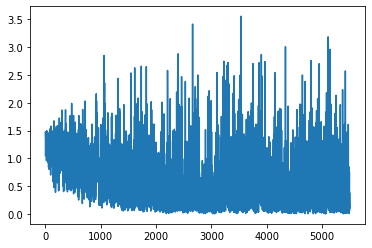

In [46]:
plt.plot(dis_loss)
plt.show()